In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Hyper Parameters
BATCH_SIZE = 100
LR_G = 1e-4           # learning rate for generator
LR_D = 1e-4           # learning rate for discriminator
N_IDEAS = 10          # think of this as number of ideas for generating an art work (Generator)
ART_COMPONENTS = 30   # it could be total point G can draw in the canvas   

In [3]:
PAINT_POINTS = []
for _ in range(0 , BATCH_SIZE):
    PAINT_POINTS.append(np.linspace(-3 , 3 , ART_COMPONENTS))
PAINT_POINTS = np.array(PAINT_POINTS) 

def artist_works():     # painting from the famous artist (real target)
    a = np.random.uniform(0 , 10 , size = BATCH_SIZE).reshape(-1 , 1)
    paintings = []
    for i in range(0 , BATCH_SIZE):
        paintings.append(10 * PAINT_POINTS[i , :] ** 3 +\
                         20 * PAINT_POINTS[i , :] ** 2 + a[i , 0])
    paintings = np.array(paintings)
    return paintings

In [4]:
def add_layer(inputs , in_size , out_size , activaction_function = None): 
    Weights = tf.get_variable(initializer = tf.truncated_normal([in_size , out_size] , mean = 0.001 , stddev = 0.3) , name = 'w_a')
    biases = tf.get_variable(initializer = tf.zeros([1 , out_size]) + 0.001 , name = 'b_a')
    Wx_plus_b = tf.add(tf.matmul(inputs , Weights) , biases) 

    # here to activaction_function
    if activaction_function is None:
        outputs = Wx_plus_b
    else:
        outputs = activaction_function(Wx_plus_b , name = 'output')
        
    return outputs 

In [5]:
# define placeholder for inputs to network
xs_G = tf.placeholder(tf.float32 , [None , N_IDEAS])
xs_D = tf.placeholder(tf.float32 , [None , ART_COMPONENTS])

In [6]:
# Generator，相當於偽造家
with tf.variable_scope('Generator'):
    with tf.variable_scope('hidden_layer'):
        layer_G = add_layer(xs_G , N_IDEAS , 128 , activaction_function = tf.nn.relu)
    with tf.variable_scope('output_layer'):
        G_out = add_layer(layer_G , 128 , ART_COMPONENTS , activaction_function = None)   

# Discriminator，相當於鑑定師
with tf.variable_scope('Discriminator'):
    with tf.variable_scope('hidden_layer'): 
        hidden_layer_for_G = add_layer(G_out , ART_COMPONENTS , 128 , activaction_function = tf.nn.relu)
        tf.get_variable_scope().reuse_variables() 
        hidden_layer_for_D = add_layer(xs_D , ART_COMPONENTS , 128 , activaction_function = tf.nn.relu)         

    with tf.variable_scope('output_layer'):
        # 在WGAN中不需要使用任何activaction_function
        artist_for_G = add_layer(hidden_layer_for_G , 128 , 1 , activaction_function = None) 
        tf.get_variable_scope().reuse_variables()
        artist_for_D = add_layer(hidden_layer_for_D , 128 , 1 , activaction_function = None) 

In [7]:
# cost function for Generator & Discriminator
G_loss = -tf.reduce_mean(artist_for_G , 0)[0] 
D_loss = tf.reduce_mean(artist_for_G - artist_for_D , 0)[0] 

In [8]:
# 訓練Generator與Discriminator時，兩者的參數分開來訓練會比較容易訓練
# 訓練Generator時，凍結Discriminator的參數
# 訓練Discriminator時，凍結Generator的參數
variable_Generator , variable_Discriminator = [] , [] 
for i in tf.trainable_variables(): 
    if 'Generator' in i.name : variable_Generator.append(i)
    if 'Discriminator' in i.name : variable_Discriminator.append(i)

train_Generator = tf.train.AdamOptimizer(LR_G).minimize(G_loss , var_list = variable_Generator)     
train_Discriminator = tf.train.AdamOptimizer(LR_D).minimize(D_loss , var_list = variable_Discriminator)

# 使用weight clipping的方法
# 對於Discriminator的參數都限制在(-clip_value , clip_value)這個範圍內
clip_value = 0.01
clip_Discriminator = []
for v in variable_Discriminator:
    clip_Discriminator.append(v.assign(tf.clip_by_value(v , -clip_value , clip_value)))

In [9]:
sess = tf.Session() 
sess.run(tf.global_variables_initializer())

G_paintings_list = []
for step in range(0 , 8000):
    
    # 訓練Discriminator5次，訓練Generator1次
    for _ in range(0 , 5):
        artist_paintings = artist_works()
        G_ideas = np.random.rand(BATCH_SIZE , N_IDEAS)
        sess.run(train_Discriminator , feed_dict = {xs_G : G_ideas , xs_D : artist_paintings})
        sess.run(clip_Discriminator)
    sess.run(train_Generator , feed_dict = {xs_G : G_ideas})
    
    artist_paintings = artist_works()
    G_ideas = np.random.rand(BATCH_SIZE , N_IDEAS)
    G_loss_ , D_loss_ =  sess.run([G_loss , D_loss] , feed_dict = {xs_G : G_ideas , xs_D : artist_paintings})
    
    if step % 200 == 0:
        print('=' * 30)
        print('step : {}'.format(step))
        print('G_loss : {:.2f} , D_loss : {:.2f}'.format(G_loss_ , D_loss_))
    
    if step % 400 == 0:
        G_paintings = sess.run(G_out , feed_dict = {xs_G : G_ideas})
        G_paintings_list.append(G_paintings[0 , :])

step : 0
G_loss : 0.00 , D_loss : -0.10
step : 200
G_loss : -0.03 , D_loss : -9.84
step : 400
G_loss : -0.09 , D_loss : -9.77
step : 600
G_loss : -0.15 , D_loss : -9.75
step : 800
G_loss : -0.24 , D_loss : -9.61
step : 1000
G_loss : -0.36 , D_loss : -9.50
step : 1200
G_loss : -0.51 , D_loss : -9.33
step : 1400
G_loss : -0.66 , D_loss : -9.19
step : 1600
G_loss : -0.82 , D_loss : -9.03
step : 1800
G_loss : -1.05 , D_loss : -8.82
step : 2000
G_loss : -1.25 , D_loss : -8.60
step : 2200
G_loss : -1.56 , D_loss : -8.31
step : 2400
G_loss : -1.82 , D_loss : -8.05
step : 2600
G_loss : -2.08 , D_loss : -7.79
step : 2800
G_loss : -2.32 , D_loss : -7.51
step : 3000
G_loss : -2.59 , D_loss : -7.28
step : 3200
G_loss : -2.94 , D_loss : -6.91
step : 3400
G_loss : -3.32 , D_loss : -6.48
step : 3600
G_loss : -3.55 , D_loss : -6.27
step : 3800
G_loss : -3.99 , D_loss : -5.84
step : 4000
G_loss : -4.39 , D_loss : -5.40
step : 4200
G_loss : -4.78 , D_loss : -5.02
step : 4400
G_loss : -5.07 , D_loss : -4

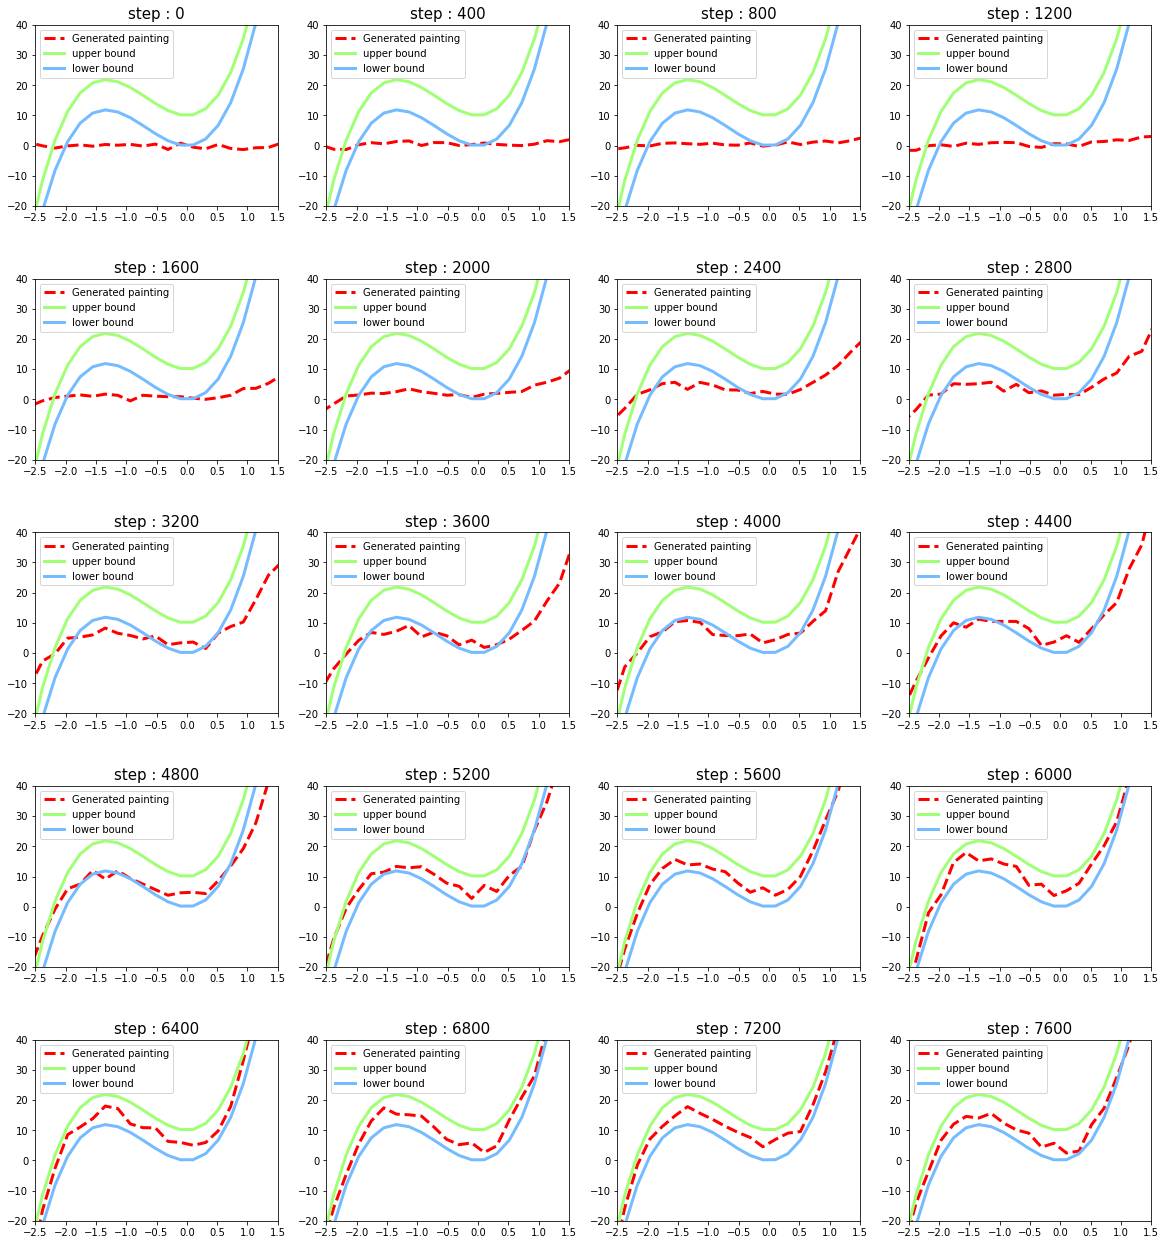

In [10]:
fig , ax = plt.subplots(5 , 4 , figsize = (20 , 22))
plt.subplots_adjust(wspace = 0.2 , hspace = 0.4)

for i in range(0 , 5):
    for j in range(0 , 4):
        G_paintings = G_paintings_list[4 * i + j]
        ax[i , j].plot(PAINT_POINTS[0 , :] , G_paintings , c = 'r' , lw = 3 , ls = '--' , label = 'Generated painting')
        
        ax[i , j].plot(PAINT_POINTS[0 , :] , 
                       10 * np.power(PAINT_POINTS[0 , :] , 3) + 20 * np.power(PAINT_POINTS[0 , :] , 2) + 10 , 
                       c = '#a0ff74' , lw = 3 , 
                       label = 'upper bound')
        
        ax[i , j].plot(PAINT_POINTS[0 , :] , 
                       10 * np.power(PAINT_POINTS[0 , :] , 3) + 20 * np.power(PAINT_POINTS[0 , :] , 2) + 0 , 
                       c = '#74BCFF' , lw = 3 , 
                       label = 'lower bound')
        
        ax[i , j].set_title('step : {:1d}'.format((4 * i + j) * 400) , fontsize = 15) 
        ax[i , j].set_xlim((-2.5 , 1.5)) 
        ax[i , j].set_ylim((-20 , 40))
        ax[i , j].legend(loc = 'upper left' , fontsize = 10)